# インポート

In [597]:
import urllib.request as req
import urllib.error
import time
from bs4 import BeautifulSoup
from pathlib import Path
import json

## 結果ページ回号一覧を取得

In [478]:
url = "https://takarakuji.rakuten.co.jp/backnumber/loto6_past/"
html = req.urlopen(url).read()
soup = BeautifulSoup(html)
soup

<!DOCTYPE html>
<!--[if IE 8 ]><html class="ie ie8" lang="ja" prefix="og: http://ogp.me/ns# fb: http://www.facebook.com/2008/fbml"><![endif]--><!--[if IE 9 ]><html class="ie ie9" lang="ja" prefix="og: http://ogp.me/ns# fb: http://www.facebook.com/2008/fbml"><![endif]--><!--[if !(IE)]><!--><html lang="ja" prefix="og: http://ogp.me/ns# fb: http://www.facebook.com/2008/fbml">
<!--<![endif]-->
<head>
<meta charset="utf-8"/>
<title>ロト6(LOTO6)過去の当せん番号案内-楽天×宝くじ</title>
<meta content="ロト6（LOTO6）過去の当せん番号をご案内します。楽天×宝くじでは最新の当せん番号からから過去の当せん番号まで全ての番号が確認できます。" name="description"/>
<meta content="楽天,rakuten,宝くじ,ロト,ロト6,LOTO,LOTO6,当選番号当せん番号,過去" name="keywords"/>
<meta content="ロト6(LOTO6)過去の当せん番号案内-楽天×宝くじ" property="og:title"/>
<meta content="ロト6（LOTO6）過去の当せん番号をご案内します。楽天×宝くじでは最新の当せん番号からから過去の当せん番号まで全ての番号が確認できます。" property="og:description"/>
<meta content="website" property="og:type"/>
<meta content="楽天×宝くじ" property="og:site_name"/>
<meta content="http://takarakuji.rakuten.co.jp/image/og/og.jpg" property

In [920]:
issue_number_list = []

for a in soup.select("ul.linkType01 a"):
    href = a.get("href")
    if href.startswith(("/backnumber/loto6/", "/backnumber/loto6_detail/")):
        issue_number_list.append(href.strip("/").split("/")[-1])

issue_number_list

['202601',
 '202512',
 '202511',
 '202510',
 '202509',
 '202508',
 '202507',
 '202506',
 '202505',
 '202504',
 '202503',
 '202502',
 '0001-0020',
 '0021-0040',
 '0041-0060',
 '0061-0080',
 '0081-0100',
 '0101-0120',
 '0121-0140',
 '0141-0160',
 '0161-0180',
 '0181-0200',
 '0201-0220',
 '0221-0240',
 '0241-0260',
 '0261-0280',
 '0281-0300',
 '0301-0320',
 '0321-0340',
 '0341-0360',
 '0361-0380',
 '0381-0400',
 '0401-0420',
 '0421-0440',
 '0441-0460',
 '0461-0480',
 '0481-0500',
 '0501-0520',
 '0521-0540',
 '0541-0560',
 '0561-0580',
 '0581-0600',
 '0601-0620',
 '0621-0640',
 '0641-0660',
 '0661-0680',
 '0681-0700',
 '0701-0720',
 '0721-0740',
 '0741-0760',
 '0761-0780',
 '0781-0800',
 '0801-0820',
 '0821-0840',
 '0841-0860',
 '0861-0880',
 '0881-0900',
 '0901-0920',
 '0921-0940',
 '0941-0960',
 '0961-0980',
 '0981-1000',
 '1001-1020',
 '1021-1040',
 '1041-1060',
 '1061-1080',
 '1081-1100',
 '1101-1120',
 '1121-1140',
 '1141-1160',
 '1161-1180',
 '1181-1200',
 '1201-1220',
 '1221-1240',


In [921]:
def scrape_issue_number():
    """
    結果一覧ページのサイトにアクセスして、issue_numberを取得する関数
    該当ページが存在しない（404）の場合はスキップ
    """
    issue_number_list = []
    url = "https://takarakuji.rakuten.co.jp/backnumber/loto6_past/"
    try:
        html = req.urlopen(url).read()
    except urllib.error.HTTPError as e:
        if e.code == 404:
            return []  # 404のときは空のリストを返してスキップ
        else:
            raise e  # 他のエラーは再スロー
    try:
        time.sleep(1)
        soup = BeautifulSoup(html, "html.parser")
        for a in soup.select("ul.linkType01 a"):
            href = a.get("href")
            if href.startswith(("/backnumber/loto6/", "/backnumber/loto6_detail/")):
                issue_number_list.append(href.strip("/").split("/")[-1])
    except Exception:
        return []
    return issue_number_list

In [922]:
issue_number_list = scrape_issue_number()
issue_number_list

['202601',
 '202512',
 '202511',
 '202510',
 '202509',
 '202508',
 '202507',
 '202506',
 '202505',
 '202504',
 '202503',
 '202502',
 '0001-0020',
 '0021-0040',
 '0041-0060',
 '0061-0080',
 '0081-0100',
 '0101-0120',
 '0121-0140',
 '0141-0160',
 '0161-0180',
 '0181-0200',
 '0201-0220',
 '0221-0240',
 '0241-0260',
 '0261-0280',
 '0281-0300',
 '0301-0320',
 '0321-0340',
 '0341-0360',
 '0361-0380',
 '0381-0400',
 '0401-0420',
 '0421-0440',
 '0441-0460',
 '0461-0480',
 '0481-0500',
 '0501-0520',
 '0521-0540',
 '0541-0560',
 '0561-0580',
 '0581-0600',
 '0601-0620',
 '0621-0640',
 '0641-0660',
 '0661-0680',
 '0681-0700',
 '0701-0720',
 '0721-0740',
 '0741-0760',
 '0761-0780',
 '0781-0800',
 '0801-0820',
 '0821-0840',
 '0841-0860',
 '0861-0880',
 '0881-0900',
 '0901-0920',
 '0921-0940',
 '0941-0960',
 '0961-0980',
 '0981-1000',
 '1001-1020',
 '1021-1040',
 '1041-1060',
 '1061-1080',
 '1081-1100',
 '1101-1120',
 '1121-1140',
 '1141-1160',
 '1161-1180',
 '1181-1200',
 '1201-1220',
 '1221-1240',


### issue_number_listを保存

In [923]:
# Jupyter（.ipynb）では__file__ が存在しないため実行できない。

def write_issue_number(issue_number_list):
    """
    issue_number_listをjsonで保存する関数
    """
    # このファイル自身の場所（scripts/）
    base_dir = Path(__file__).resolve().parent
    # /boatrace/db/scrape_race_schedule_dict.json
    json_path = base_dir.parent / "db" / "issue_number_list.json"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(issue_number_list, f, ensure_ascii=False, indent=2)

In [924]:
with open("../db/issue_number.json", "w", encoding="utf-8") as f:
        json.dump(issue_number_list, f, ensure_ascii=False, indent=2)

## issue_numberを取得

In [925]:
# Jupyter（.ipynb）では__file__ が存在しないため実行できない。

def read_issue_number():
    """
    issue_numberをjsonで取得する関数
    """
    # このファイル自身の場所（scripts/）
    base_dir = Path(__file__).resolve().parent
    # /boatrace/db/scrape_race_schedule_dict.json
    json_path = base_dir.parent / "db" / "issue_number.json"
    with open(json_path, "r", encoding="utf-8") as f:
        issue_number_list = json.load(f)
    return issue_number_list

In [926]:
with open("../db/issue_number.json", "rb") as f:
    issue_number_list = json.load(f)

In [927]:
issue_number_list

['202601',
 '202512',
 '202511',
 '202510',
 '202509',
 '202508',
 '202507',
 '202506',
 '202505',
 '202504',
 '202503',
 '202502',
 '0001-0020',
 '0021-0040',
 '0041-0060',
 '0061-0080',
 '0081-0100',
 '0101-0120',
 '0121-0140',
 '0141-0160',
 '0161-0180',
 '0181-0200',
 '0201-0220',
 '0221-0240',
 '0241-0260',
 '0261-0280',
 '0281-0300',
 '0301-0320',
 '0321-0340',
 '0341-0360',
 '0361-0380',
 '0381-0400',
 '0401-0420',
 '0421-0440',
 '0441-0460',
 '0461-0480',
 '0481-0500',
 '0501-0520',
 '0521-0540',
 '0541-0560',
 '0561-0580',
 '0581-0600',
 '0601-0620',
 '0621-0640',
 '0641-0660',
 '0661-0680',
 '0681-0700',
 '0701-0720',
 '0721-0740',
 '0741-0760',
 '0761-0780',
 '0781-0800',
 '0801-0820',
 '0821-0840',
 '0841-0860',
 '0861-0880',
 '0881-0900',
 '0901-0920',
 '0921-0940',
 '0941-0960',
 '0961-0980',
 '0981-1000',
 '1001-1020',
 '1021-1040',
 '1041-1060',
 '1061-1080',
 '1081-1100',
 '1101-1120',
 '1121-1140',
 '1141-1160',
 '1161-1180',
 '1181-1200',
 '1201-1220',
 '1221-1240',


## テーブルの取得

In [928]:
import urllib.request as req

url = "https://takarakuji.rakuten.co.jp/backnumber/loto6/202601/"
html = req.urlopen(url).read()

In [929]:
import pandas as pd

pd.read_html(html, encoding="utf-8")

[         回号        第2065回      第2065回.1      第2065回.2      第2065回.3  \
 0      抽せん日    2026/01/05    2026/01/05    2026/01/05    2026/01/05   
 1       本数字             6            18            21            31   
 2    ボーナス数字           (3)           NaN           NaN           NaN   
 3        1等          該当なし          該当なし          該当なし          該当なし   
 4        2等            5口            5口            5口   15,198,300円   
 5        3等          215口          215口          215口      381,700円   
 6        4等       10,741口       10,741口       10,741口        8,000円   
 7        5等      178,338口      178,338口      178,338口        1,000円   
 8  キャリーオーバー  259,218,384円  259,218,384円  259,218,384円  259,218,384円   
 
        第2065回.4      第2065回.5  
 0    2026/01/05    2026/01/05  
 1            37            40  
 2           NaN           NaN  
 3          該当なし          該当なし  
 4   15,198,300円   15,198,300円  
 5      381,700円      381,700円  
 6        8,000円        8,000円  
 7        1,00

## htmlの取得

In [930]:
from pathlib import Path

HTML_DIR = Path("..", "data", "html")
HTML_DIR

PosixPath('../data/html')

In [ ]:
import time

for issue_number in issue_number_list:
    if "-" not in issue_number:
        url = f"https://takarakuji.rakuten.co.jp/backnumber/loto6/{issue_number}/"
    else:
        url = f"https://takarakuji.rakuten.co.jp/backnumber/loto6_detail/{issue_number}/"
    html = req.urlopen(url).read()
    time.sleep(1)
    with open(HTML_DIR / f"{issue_number}.bin", "wb") as f:
        f.write(html)

In [932]:
from tqdm.notebook import tqdm

def write_html(issue_number_list, save_dir: Path):
    html_path_list = []
    for issue_number in tqdm(issue_number_list):
        filepath = save_dir / f"{issue_number}.bin"
        # binファイルがすでに存在する場合はスキップする
        if filepath.is_file():
            print(f"skipped: {issue_number}")
        else:
            if "-" not in issue_number:
                url = f"https://takarakuji.rakuten.co.jp/backnumber/loto6/{issue_number}/"
            else:
                url = f"https://takarakuji.rakuten.co.jp/backnumber/loto6_detail/{issue_number}/"
            html = req.urlopen(url).read()
            time.sleep(1)
            with open(filepath, "wb") as f:
                f.write(html)
            html_path_list.append(filepath)
    return html_path_list

In [933]:
html_path_list = write_html(issue_number_list, save_dir=HTML_DIR)

  0%|          | 0/111 [00:00<?, ?it/s]

skipped: 202601
skipped: 202512
skipped: 202511
skipped: 202510
skipped: 202509
skipped: 202508
skipped: 202507
skipped: 202506
skipped: 202505
skipped: 202504
skipped: 202503
skipped: 202502
skipped: 0001-0020
skipped: 0021-0040
skipped: 0041-0060
skipped: 0061-0080
skipped: 0081-0100
skipped: 0101-0120
skipped: 0121-0140
skipped: 0141-0160
skipped: 0161-0180
skipped: 0181-0200
skipped: 0201-0220
skipped: 0221-0240
skipped: 0241-0260
skipped: 0261-0280
skipped: 0281-0300
skipped: 0301-0320
skipped: 0321-0340
skipped: 0341-0360
skipped: 0361-0380
skipped: 0381-0400
skipped: 0401-0420
skipped: 0421-0440
skipped: 0441-0460
skipped: 0461-0480
skipped: 0481-0500
skipped: 0501-0520
skipped: 0521-0540
skipped: 0541-0560
skipped: 0561-0580
skipped: 0581-0600
skipped: 0601-0620
skipped: 0621-0640
skipped: 0641-0660
skipped: 0661-0680
skipped: 0681-0700
skipped: 0701-0720
skipped: 0721-0740
skipped: 0741-0760
skipped: 0761-0780
skipped: 0781-0800
skipped: 0801-0820
skipped: 0821-0840
skipped: 0

In [934]:
html_path_list

[]

In [935]:
html_path_list = list(HTML_DIR.glob("*"))
len(html_path_list)

111

## 結果テーブルの取得

In [936]:
df3 = {}
with open('../data/html/0521-0540.bin', "rb") as f:
    html = f.read()
    dfs = pd.read_html(html)

    # 「抽せん日 / 抽選日」を含む table だけ抽出
    indexes = []
    for i, df in enumerate(dfs):
        if df.astype(str).apply(lambda x: x.str.contains("抽せん日|抽選日", na=False)).any().any():
            indexes.append(i)

    # 条件に合うものがあればそれだけ、なければ全部
    if indexes:
        target_dfs = [dfs[i] for i in indexes]
    else:
        target_dfs = dfs

    # index[回号]を設定、テーブルのを結合
    for df in target_dfs:
        # 「1等」がデータ内に含まれているか判定
        if df.astype(str).apply(lambda x: x.str.contains("1等", na=False)).any().any():
            df2 = df.drop(index=range(3, 9), errors="ignore")
            kaigou_id = df2.columns[1]
            lottery_day = df2.iat[0, 2]
            insert = df2.columns[0]
            df2.loc[df2[insert].astype(str).str.strip() == "本数字", insert] = lottery_day
            bonus_number = df2.iat[2, 1].strip("()")
            df2['bonus'] = bonus_number
            df2 = df2.drop(index=range(0, 1), errors="ignore")
            df2 = df2.drop(index=range(2, 3), errors="ignore")
            df2.columns = ['抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'bonus']
            df2.insert(0, "回号", kaigou_id)
            df2 = df2.reset_index(drop=True)
            df3[kaigou_id] = df2
        else:
            kaigou_id = '回号'
            df.columns = ['回号', '抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'bonus']
            df3[kaigou_id] = df
results_df = pd.concat(df3.values())
results_df

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus
0,第0521回,2010/11/04,1,8,15,21,23,30,33
1,第0522回,2010/11/11,3,6,16,23,25,43,37
2,第0523回,2010/11/18,7,8,26,27,41,43,16
3,第0524回,2010/11/25,7,11,14,18,35,40,43
4,第0525回,2010/12/02,1,11,17,28,33,38,20
5,第0526回,2010/12/09,8,14,18,19,26,27,23
6,第0527回,2010/12/16,5,7,12,23,39,41,9
7,第0528回,2010/12/23,2,5,12,21,28,32,41
8,第0529回,2010/12/30,6,19,21,24,31,41,7
9,第0530回,2011/01/06,1,10,19,30,33,36,35


In [937]:
frames = []
for html_path in html_path_list:
    with open(html_path, "rb") as f:
        html = f.read()
        dfs = pd.read_html(html)

        # 「抽せん日 / 抽選日」を含む table だけ抽出
        indexes = []
        for i, df in enumerate(dfs):
            if df.astype(str).apply(lambda x: x.str.contains("抽せん日|抽選日", na=False)).any().any():
                indexes.append(i)

        # 条件に合うものがあればそれだけ、なければ全部
        if indexes:
            target_dfs = [dfs[i] for i in indexes]
        else:
            target_dfs = dfs

        # index[回号]を設定、テーブルのを結合
        for df in target_dfs:
            # 「1等」がデータ内に含まれているか判定
            if df.astype(str).apply(lambda x: x.str.contains("1等", na=False)).any().any():
                df2 = df.drop(index=range(3, 9), errors="ignore")
                kaigou_id = df2.columns[1]
                lottery_day = df2.iat[0, 2]
                insert = df2.columns[0]
                df2.loc[df2[insert].astype(str).str.strip() == "本数字", insert] = lottery_day
                bonus_number = df2.iat[2, 1].strip("()")
                df2['bonus'] = bonus_number
                df2 = df2.drop(index=range(0, 1), errors="ignore")
                df2 = df2.drop(index=range(2, 3), errors="ignore")
                df2.columns = ['抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'bonus']
                df2.insert(0, "回号", kaigou_id)
                df2 = df2.reset_index(drop=True)
                frames.append(df2)
            else:
                kaigou_id = '回号'
                df.columns = ['回号', '抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'bonus']
                frames.append(df)
results_df = pd.concat(frames)
results_df = results_df.reset_index(drop=True)
# 抽選日を datetime に変換
results_df["抽せん日"] = pd.to_datetime(results_df["抽せん日"])
# 最新順に並び替え
results_df = results_df.sort_values("抽せん日", ascending=False).reset_index(drop=True)

In [938]:
results_df

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus
0,第2070回,2026-01-22,6,10,25,30,34,36,12
1,第2069回,2026-01-19,6,17,23,27,33,35,4
2,第2068回,2026-01-15,2,10,13,14,29,33,32
3,第2067回,2026-01-12,3,4,12,15,32,42,31
4,第2066回,2026-01-08,8,28,30,32,37,38,5
...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43
2066,第0004回,2000-10-26,16,18,26,27,34,40,13
2067,第0003回,2000-10-19,1,5,15,31,36,38,13
2068,第0002回,2000-10-12,1,9,16,20,21,43,5


In [939]:
def create_results_df(html_path_list):
    """
    結果ページのhtmlを読み込んで、結果テーブルに加工する関数
    """
    frames = []
    for html_path in html_path_list:
        with open(html_path, "rb") as f:
            html = f.read()
            dfs = pd.read_html(html)

            # 「抽せん日 / 抽選日」を含む table だけ抽出
            indexes = []
            for i, df in enumerate(dfs):
                if df.astype(str).apply(lambda x: x.str.contains("抽せん日|抽選日", na=False)).any().any():
                    indexes.append(i)

            # 条件に合うものがあればそれだけ、なければ全部
            if indexes:
                target_dfs = [dfs[i] for i in indexes]
            else:
                target_dfs = dfs

            # index[回号]を設定、テーブルのを結合
            for df in target_dfs:
                # 「1等」がデータ内に含まれているか判定
                if df.astype(str).apply(lambda x: x.str.contains("1等", na=False)).any().any():
                    df2 = df.drop(index=range(3, 9), errors="ignore")
                    kaigou_id = df2.columns[1]
                    lottery_day = df2.iat[0, 2]
                    insert = df2.columns[0]
                    df2.loc[df2[insert].astype(str).str.strip() == "本数字", insert] = lottery_day
                    bonus_number = df2.iat[2, 1].strip("()")
                    df2['bonus'] = bonus_number
                    df2 = df2.drop(index=range(0, 1), errors="ignore")
                    df2 = df2.drop(index=range(2, 3), errors="ignore")
                    df2.columns = ['抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'bonus']
                    df2.insert(0, "回号", kaigou_id)
                    df2 = df2.reset_index(drop=True)
                    frames.append(df2)
                else:
                    kaigou_id = '回号'
                    df.columns = ['回号', '抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'bonus']
                    frames.append(df)
    results_df = pd.concat(frames)
    results_df = results_df.reset_index(drop=True)
    # 抽選日を datetime に変換
    results_df["抽せん日"] = pd.to_datetime(results_df["抽せん日"])
    # 最新順に並び替え
    results_df = results_df.sort_values("抽せん日", ascending=False).reset_index(drop=True)
    return results_df

In [940]:
results_df = create_results_df(html_path_list=html_path_list)
results_df

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus
0,第2070回,2026-01-22,6,10,25,30,34,36,12
1,第2069回,2026-01-19,6,17,23,27,33,35,4
2,第2068回,2026-01-15,2,10,13,14,29,33,32
3,第2067回,2026-01-12,3,4,12,15,32,42,31
4,第2066回,2026-01-08,8,28,30,32,37,38,5
...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43
2066,第0004回,2000-10-26,16,18,26,27,34,40,13
2067,第0003回,2000-10-19,1,5,15,31,36,38,13
2068,第0002回,2000-10-12,1,9,16,20,21,43,5


In [941]:
save_dir = Path("..", "data", "rawdf")

In [942]:
results_df.to_csv(save_dir / "results.csv", sep="\t", index=False)

## 分布特徴量テーブルに加工

In [943]:
from collections import Counter

RECENT_NUMBER = 50 # 直近50回のデータで分析
NUM_COLS = ['nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6']

def create_results_distribution_features_df(results_df):
    df = results_df.sort_values("回号").reset_index(drop=True)
    # 本数字をintに変更
    df[NUM_COLS] = df[NUM_COLS].apply(pd.to_numeric, errors="coerce").astype("Int64")

    def main_number_zone(rank):
        if 0 < rank and rank <= 14:
            return "top"
        elif 14 < rank and rank <= 29:
            return "mid"
        elif 29 < rank and rank <= 43:
            return "low"

    records = []
    for i in range(len(df)):
        if i < RECENT_NUMBER:
            # 直前50回が揃っていない回はスキップ
            continue

        current = df.iloc[i]
        past = df.iloc[i-RECENT_NUMBER:i]

        # 直前50回の出現回数集計
        nums = []
        for _, row in past.iterrows():
            nums.extend([row[c] for c in NUM_COLS])

        freq = Counter(nums)

        # 出ていない数字も含める（1〜43）
        all_nums = list(range(1, 44))
        ranking = sorted(
            all_nums,
            key=lambda x: (-freq.get(x, 0), x)
        )

        rank_map = {num: r+1 for r, num in enumerate(ranking)}

        # 今回の本数字の順位
        current_nums = [current[c] for c in NUM_COLS]
        current_nums = [int(x) for x in current_nums if pd.notna(x)]  # NaN除去 + int化

        ranks = [rank_map[n] for n in current_nums]

        # 順位帯分布
        zones = [main_number_zone(r) for r in ranks]
        rank_top = zones.count("top")
        rank_mid = zones.count("mid")
        rank_low = zones.count("low")

        # 要約指標
        mean_rank = sum(ranks) / len(ranks)
        min_rank  = min(ranks)
        max_rank  = max(ranks)

        records.append({
            "回号": current["回号"],
            "1~14_rank_cnt": rank_top,
            "15~29_rank_cnt": rank_mid,
            "30~43_rank_cnt": rank_low,
            "mean_rank": round(mean_rank, 2),
            "min_rank": min_rank,
            "max_rank": max_rank,
            "rank_map": rank_map
        })

    results_distribution_features_df = pd.DataFrame(records)
    # 最新順に並び替え
    results_distribution_features_df = results_distribution_features_df.sort_values("回号", ascending=False).reset_index(drop=True)
    return results_distribution_features_df

In [944]:
results_distribution_features_df = create_results_distribution_features_df(results_df=results_df)
results_distribution_features_df

,回号,1~14_rank_cnt,15~29_rank_cnt,30~43_rank_cnt,mean_rank,min_rank,max_rank,rank_map
0,第2070回,1,2,3,28.67,11,43,"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7..."
1,第2069回,0,1,5,33.50,23,41,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
2,第2068回,2,4,0,16.00,3,27,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
3,第2067回,2,2,2,23.83,2,40,"{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7..."
4,第2066回,3,0,3,24.00,8,41,"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,..."
...,...,...,...,...,...,...,...,...
2015,第0055回,2,3,1,17.50,2,36,"{25: 1, 37: 2, 38: 3, 41: 4, 11: 5, 20: 6, 21:..."
2016,第0054回,2,1,3,22.50,1,41,"{25: 1, 37: 2, 38: 3, 41: 4, 11: 5, 20: 6, 21:..."
2017,第0053回,2,2,2,20.50,3,34,"{25: 1, 38: 2, 37: 3, 41: 4, 11: 5, 20: 6, 21:..."
2018,第0052回,2,1,3,24.50,4,38,"{38: 1, 20: 2, 21: 3, 25: 4, 37: 5, 41: 6, 11:..."


In [945]:
save_dir = Path("..", "data", "rawdf")

In [946]:
results_distribution_features_df.to_csv(save_dir / "results_distribution_features.csv", sep="\t", index=False)

## results_distribution_features_dfをランクにおいての平均値・標準偏差・中央値で求める

In [947]:
df = results_distribution_features_df.copy()

FEATURE_COLS = [
    "1~14_rank_cnt",
    "15~29_rank_cnt",
    "30~43_rank_cnt",
    "mean_rank",
    "min_rank",
    "max_rank"
]

stats = df[FEATURE_COLS].agg(["mean", "std"]).round(3)
median = df[FEATURE_COLS].median().round(3)
summary = stats.copy()
summary.loc["median"] = median
summary.to_csv(save_dir / "results_mean_std_median.csv", sep="\t", index=False)
summary

,1~14_rank_cnt,15~29_rank_cnt,30~43_rank_cnt,mean_rank,min_rank,max_rank
mean,1.974,2.069,1.957,21.991,6.320,37.813
std,1.082,1.112,1.070,4.716,5.039,4.815
median,2.000,2.000,2.000,22.000,5.000,39.000


In [948]:
def create_results_distribution_features_df_mean_std_median(results_distribution_features_df):
    FEATURE_COLS = [
        "1~14_rank_cnt",
        "15~29_rank_cnt",
        "30~43_rank_cnt",
        "mean_rank",
        "min_rank",
        "max_rank"
    ]
    mean_std = results_distribution_features_df[FEATURE_COLS].agg(["mean", "std"]).round(3)
    median = results_distribution_features_df[FEATURE_COLS].median().round(3)
    results_distribution_features_df_mean_std_median = mean_std.copy()
    results_distribution_features_df_mean_std_median.loc["median"] = median
    return results_distribution_features_df_mean_std_median

In [949]:
results_distribution_features_df_mean_std_median = create_results_distribution_features_df_mean_std_median(results_distribution_features_df)
results_distribution_features_df_mean_std_median

,1~14_rank_cnt,15~29_rank_cnt,30~43_rank_cnt,mean_rank,min_rank,max_rank
mean,1.974,2.069,1.957,21.991,6.320,37.813
std,1.082,1.112,1.070,4.716,5.039,4.815
median,2.000,2.000,2.000,22.000,5.000,39.000


## results_distribution_features_dfをada(高度データ分析)に加工

In [950]:
for col in FEATURE_COLS:
    mean = stats.loc["mean", col]
    std  = stats.loc["std", col]

    results_distribution_features_df[f"{col}_z"] = (results_distribution_features_df[col] - mean) / std
results_distribution_features_df

,回号,1~14_rank_cnt,15~29_rank_cnt,30~43_rank_cnt,mean_rank,min_rank,max_rank,rank_map,1~14_rank_cnt_z,15~29_rank_cnt_z,30~43_rank_cnt_z,mean_rank_z,min_rank_z,max_rank_z
0,第2070回,1,2,3,28.67,11,43,"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7...",-0.900185,-0.062050,0.974766,1.416243,0.928756,1.077259
1,第2069回,0,1,5,33.50,23,41,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",-1.824399,-0.961331,2.843925,2.440416,3.310181,0.661890
2,第2068回,2,4,0,16.00,3,27,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",0.024030,1.736511,-1.828972,-1.270356,-0.658861,-2.245691
3,第2067回,2,2,2,23.83,2,40,"{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",0.024030,-0.062050,0.040187,0.389949,-0.857313,0.454206
4,第2066回,3,0,3,24.00,8,41,"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",0.948244,-1.860612,0.974766,0.425997,0.333399,0.661890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,第0055回,2,3,1,17.50,2,36,"{25: 1, 37: 2, 38: 3, 41: 4, 11: 5, 20: 6, 21:...",0.024030,0.837230,-0.894393,-0.952290,-0.857313,-0.376532
2016,第0054回,2,1,3,22.50,1,41,"{25: 1, 37: 2, 38: 3, 41: 4, 11: 5, 20: 6, 21:...",0.024030,-0.961331,0.974766,0.107930,-1.055765,0.661890
2017,第0053回,2,2,2,20.50,3,34,"{25: 1, 38: 2, 37: 3, 41: 4, 11: 5, 20: 6, 21:...",0.024030,-0.062050,0.040187,-0.316158,-0.658861,-0.791900
2018,第0052回,2,1,3,24.50,4,38,"{38: 1, 20: 2, 21: 3, 25: 4, 37: 5, 41: 6, 11:...",0.024030,-0.961331,0.974766,0.532019,-0.460409,0.038837


In [951]:
results_distribution_features_df["anomaly_score"] = (
    results_distribution_features_df["1~14_rank_cnt_z"].abs()
  + results_distribution_features_df["15~29_rank_cnt_z"].abs()
  + results_distribution_features_df["30~43_rank_cnt_z"].abs()
).round(3)
results_distribution_features_df.to_csv(save_dir / "results_ada.csv", sep="\t", index=False)
results_distribution_features_df

,回号,1~14_rank_cnt,15~29_rank_cnt,30~43_rank_cnt,mean_rank,min_rank,max_rank,rank_map,1~14_rank_cnt_z,15~29_rank_cnt_z,30~43_rank_cnt_z,mean_rank_z,min_rank_z,max_rank_z,anomaly_score
0,第2070回,1,2,3,28.67,11,43,"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7...",-0.900185,-0.062050,0.974766,1.416243,0.928756,1.077259,1.937
1,第2069回,0,1,5,33.50,23,41,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",-1.824399,-0.961331,2.843925,2.440416,3.310181,0.661890,5.630
2,第2068回,2,4,0,16.00,3,27,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",0.024030,1.736511,-1.828972,-1.270356,-0.658861,-2.245691,3.590
3,第2067回,2,2,2,23.83,2,40,"{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",0.024030,-0.062050,0.040187,0.389949,-0.857313,0.454206,0.126
4,第2066回,3,0,3,24.00,8,41,"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",0.948244,-1.860612,0.974766,0.425997,0.333399,0.661890,3.784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,第0055回,2,3,1,17.50,2,36,"{25: 1, 37: 2, 38: 3, 41: 4, 11: 5, 20: 6, 21:...",0.024030,0.837230,-0.894393,-0.952290,-0.857313,-0.376532,1.756
2016,第0054回,2,1,3,22.50,1,41,"{25: 1, 37: 2, 38: 3, 41: 4, 11: 5, 20: 6, 21:...",0.024030,-0.961331,0.974766,0.107930,-1.055765,0.661890,1.960
2017,第0053回,2,2,2,20.50,3,34,"{25: 1, 38: 2, 37: 3, 41: 4, 11: 5, 20: 6, 21:...",0.024030,-0.062050,0.040187,-0.316158,-0.658861,-0.791900,0.126
2018,第0052回,2,1,3,24.50,4,38,"{38: 1, 20: 2, 21: 3, 25: 4, 37: 5, 41: 6, 11:...",0.024030,-0.961331,0.974766,0.532019,-0.460409,0.038837,1.960


In [952]:
def create_results_distribution_features_df_ada(results_distribution_features_df):
    """
    分布特徴量テーブルを読み込んで、高度データ分析テーブルに加工する関数
    """
    results_distribution_features_df_ada = results_distribution_features_df.copy()
    mean_std = results_distribution_features_df[FEATURE_COLS].agg(["mean", "std"])
    for col in FEATURE_COLS:
        mean = mean_std.loc["mean", col]
        std  = mean_std.loc["std", col]
        results_distribution_features_df_ada[f"{col}_z"] = ((results_distribution_features_df_ada[col] - mean) / std).round(3)
    results_distribution_features_df_ada["anomaly_score"] = (
        results_distribution_features_df_ada["1~14_rank_cnt_z"].abs()
    + results_distribution_features_df_ada["15~29_rank_cnt_z"].abs()
    + results_distribution_features_df_ada["30~43_rank_cnt_z"].abs()
    ).round(3)
    results_distribution_features_df_ada = results_distribution_features_df_ada[['回号', '1~14_rank_cnt', '15~29_rank_cnt', '30~43_rank_cnt', 'mean_rank','min_rank', 'max_rank','1~14_rank_cnt_z', '15~29_rank_cnt_z', '30~43_rank_cnt_z', 'mean_rank_z', 'min_rank_z', 'max_rank_z', 'anomaly_score', 'rank_map']]
    return results_distribution_features_df_ada

In [953]:
results_distribution_features_df_ada = create_results_distribution_features_df_ada(results_distribution_features_df=results_distribution_features_df)
results_distribution_features_df_ada

,回号,1~14_rank_cnt,15~29_rank_cnt,30~43_rank_cnt,mean_rank,min_rank,max_rank,1~14_rank_cnt_z,15~29_rank_cnt_z,30~43_rank_cnt_z,mean_rank_z,min_rank_z,max_rank_z,anomaly_score,rank_map
0,第2070回,1,2,3,28.67,11,43,-0.900,-0.062,0.975,1.416,0.929,1.077,1.937,"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7..."
1,第2069回,0,1,5,33.50,23,41,-1.823,-0.961,2.844,2.440,3.310,0.662,5.628,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
2,第2068回,2,4,0,16.00,3,27,0.024,1.736,-1.829,-1.270,-0.659,-2.246,3.589,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
3,第2067回,2,2,2,23.83,2,40,0.024,-0.062,0.040,0.390,-0.857,0.454,0.126,"{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7..."
4,第2066回,3,0,3,24.00,8,41,0.948,-1.860,0.975,0.426,0.333,0.662,3.783,"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,第0055回,2,3,1,17.50,2,36,0.024,0.837,-0.894,-0.952,-0.857,-0.377,1.755,"{25: 1, 37: 2, 38: 3, 41: 4, 11: 5, 20: 6, 21:..."
2016,第0054回,2,1,3,22.50,1,41,0.024,-0.961,0.975,0.108,-1.056,0.662,1.960,"{25: 1, 37: 2, 38: 3, 41: 4, 11: 5, 20: 6, 21:..."
2017,第0053回,2,2,2,20.50,3,34,0.024,-0.062,0.040,-0.316,-0.659,-0.792,0.126,"{25: 1, 38: 2, 37: 3, 41: 4, 11: 5, 20: 6, 21:..."
2018,第0052回,2,1,3,24.50,4,38,0.024,-0.961,0.975,0.532,-0.460,0.039,1.960,"{38: 1, 20: 2, 21: 3, 25: 4, 37: 5, 41: 6, 11:..."


### anomaly_scoreの高い順に並び替え

In [955]:
df_sorted = results_distribution_features_df_ada.sort_values("anomaly_score", ascending=False)

df_sorted[[
    "回号",
    "anomaly_score",
    "1~14_rank_cnt",
    "15~29_rank_cnt",
    "30~43_rank_cnt",
    "mean_rank",
    "min_rank",
    "max_rank"
]].head(10)

,回号,anomaly_score,1~14_rank_cnt,15~29_rank_cnt,30~43_rank_cnt,mean_rank,min_rank,max_rank
1413,第0657回,7.186,0,6,0,23.00,19,28
1727,第0343回,7.186,0,6,0,20.33,16,28
920,第1150回,5.628,0,1,5,37.00,26,43
398,第1672回,5.628,0,1,5,34.17,20,43
121,第1949回,5.628,0,1,5,33.50,21,42
899,第1171回,5.628,0,1,5,33.33,17,43
1832,第0238回,5.628,0,1,5,35.00,27,43
445,第1625回,5.628,0,1,5,32.33,24,41
1,第2069回,5.628,0,1,5,33.50,23,41
1475,第0595回,5.628,0,1,5,34.83,29,41


### anomaly_scoreのグラフ

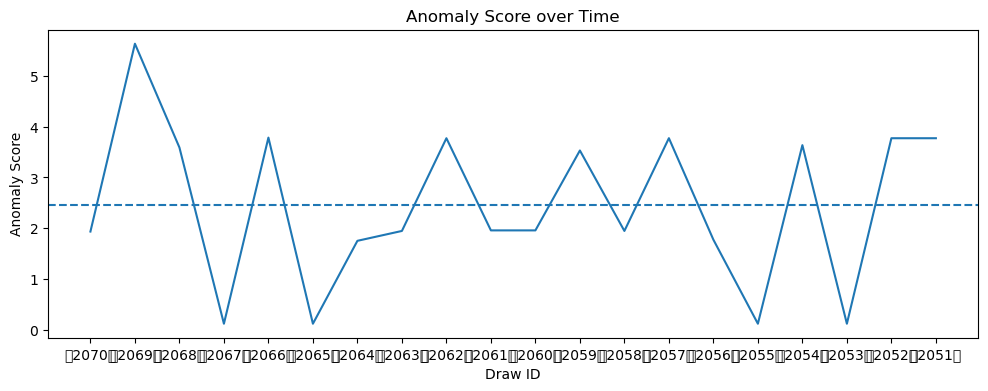

In [957]:
df = results_distribution_features_df_ada[:20]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df["回号"], df["anomaly_score"])
plt.axhline(df["anomaly_score"].mean(), linestyle="--")
plt.title("Anomaly Score over Time")
plt.xlabel("Draw ID")
plt.ylabel("Anomaly Score")
plt.show()


### rank_cntのグラフ

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


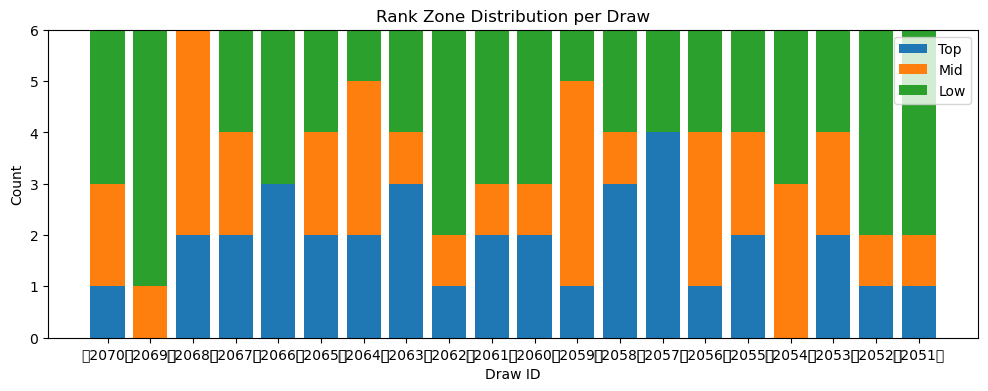

In [959]:
plt.figure(figsize=(12,4))

plt.bar(df["回号"], df["1~14_rank_cnt"], label="Top")
plt.bar(df["回号"], df["15~29_rank_cnt"],
        bottom=df["1~14_rank_cnt"], label="Mid")
plt.bar(df["回号"], df["30~43_rank_cnt"],
        bottom=df["1~14_rank_cnt"] + df["15~29_rank_cnt"], label="Low")

plt.title("Rank Zone Distribution per Draw")
plt.xlabel("Draw ID")
plt.ylabel("Count")
plt.legend()
plt.show()


### mean_rankのグラフ

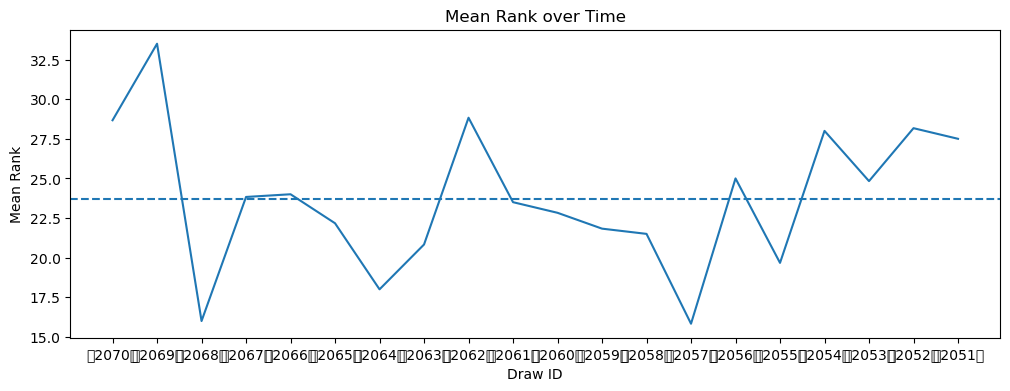

In [961]:
plt.figure(figsize=(12,4))
plt.plot(df["回号"], df["mean_rank"])
plt.axhline(df["mean_rank"].mean(), linestyle="--")
plt.title("Mean Rank over Time")
plt.xlabel("Draw ID")
plt.ylabel("Mean Rank")
plt.show()


## 連続する数字について検証（全体マップ）

観点	使う df	新たに追加する列

連続があるか	seq_pairs

連続ペアの中身	seq_values

連続数字の 	seq_mean_rank 等

連続数字のゾーン	seq_zone

連続数字の位置	seq_center_dist

連続数字のホット度	seq_hot_cnt

### 連続が出る回を検証

In [962]:
results_df_seq = results_df.sort_values("抽せん日", ascending=True).reset_index(drop=True)
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus
0,第0001回,2000-10-05,2,8,10,13,27,30,39
1,第0002回,2000-10-12,1,9,16,20,21,43,5
2,第0003回,2000-10-19,1,5,15,31,36,38,13
3,第0004回,2000-10-26,16,18,26,27,34,40,13
4,第0005回,2000-11-02,9,15,21,23,27,28,43
...,...,...,...,...,...,...,...,...,...
2065,第2066回,2026-01-08,8,28,30,32,37,38,5
2066,第2067回,2026-01-12,3,4,12,15,32,42,31
2067,第2068回,2026-01-15,2,10,13,14,29,33,32
2068,第2069回,2026-01-19,6,17,23,27,33,35,4


In [963]:
import numpy as np

NUM_COLS = ["nm1","nm2","nm3","nm4","nm5","nm6"]

# nm1〜nm6 を int に変換（NaN があっても落ちない）
nums = results_df_seq[NUM_COLS].apply(pd.to_numeric, errors="coerce").astype("Int64")

# 念のためソートしてから判定
nums_sorted = np.sort(nums.values, axis=1)

results_df_seq["seq_pairs"] = (np.diff(nums_sorted, axis=1) == 1).sum(axis=1)
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,seq_pairs
0,第0001回,2000-10-05,2,8,10,13,27,30,39,0
1,第0002回,2000-10-12,1,9,16,20,21,43,5,1
2,第0003回,2000-10-19,1,5,15,31,36,38,13,0
3,第0004回,2000-10-26,16,18,26,27,34,40,13,1
4,第0005回,2000-11-02,9,15,21,23,27,28,43,1
...,...,...,...,...,...,...,...,...,...,...
2065,第2066回,2026-01-08,8,28,30,32,37,38,5,1
2066,第2067回,2026-01-12,3,4,12,15,32,42,31,1
2067,第2068回,2026-01-15,2,10,13,14,29,33,32,1
2068,第2069回,2026-01-19,6,17,23,27,33,35,4,0


In [964]:
results_df_seq.groupby("seq_pairs").count()

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus
seq_pairs,,,,,,,,,
0,940,940,940,940,940,940,940,940,940
1,849,849,849,849,849,849,849,849,849
2,243,243,243,243,243,243,243,243,243
3,36,36,36,36,36,36,36,36,36
4,2,2,2,2,2,2,2,2,2


#### 仮説①
中央寄り（15〜29）が多いと連続が出やすい？

##### 評価：支持される（弱〜中）
##### 結果：中央帯に数字が寄るほど、隣接候補が増え、連続が生まれやすい

In [966]:
results_df_seq["15~29_cnt"] = (
    results_df_seq[NUM_COLS]
    .apply(lambda r: sum(15 <= int(x) <= 29 for x in r), axis=1)
)
results_df_seq.groupby(results_df_seq["seq_pairs"] > 0)["15~29_cnt"].mean()
# results_df_seq.groupby("seq_pairs")["15~29_cnt"].mean()
# results_df_seq.groupby(results_df_seq["seq_pairs"] > 0)["15~29_cnt"].describe()

seq_pairs
False    2.077660
True     2.142478
Name: 15~29_cnt, dtype: float64

#### 仮説②
直前回との“重なり”があると連続が出やすい？

##### 評価：ほぼ差なし（支持弱）
##### 結果：直前回との“近さ”は、連続発生の主因ではない

In [967]:
def near_prev(curr_arr, prev_arr):
    curr = {int(x) for x in curr_arr if pd.notna(x)}
    prev = {int(x) for x in prev_arr if pd.notna(x)}

    near = set()
    for n in prev:
        near.update([n-1, n, n+1])

    return len(curr & near)

results_df_seq["just_before_+-1"] = [
    near_prev(nums.iloc[i].values, nums.iloc[i-1].values) if i > 0 else 0
    for i in range(len(results_df_seq))
]
results_df_seq.groupby(results_df_seq["seq_pairs"] > 0)["just_before_+-1"].mean()
# results_df_seq.groupby("seq_pairs")["just_before_+-1"].mean()

seq_pairs
False    2.190426
True     2.206195
Name: just_before_+-1, dtype: float64

#### 仮説③
ホット数字（rank上位）が固まると連続が出やすい？

##### 評価：支持される（中）
##### 結果：「よく出ている数字」が複数含まれる回ほど、それらが近い値に固まり、連続が生じやすい

In [968]:
results_distribution_features_df = results_distribution_features_df.sort_values("回号", ascending=True).reset_index(drop=True)
results_distribution_features_df["seq_pairs"] = results_df_seq["seq_pairs"]

In [970]:
results_distribution_features_df.groupby(results_distribution_features_df["seq_pairs"] > 0)[
    ["mean_rank","min_rank","max_rank"]
].mean()
# results_distribution_features_df

,mean_rank,min_rank,max_rank
seq_pairs,,,
False,22.141485,6.427943,38.047305
True,21.867759,6.232223,37.621062


#### 仮説④
ばらけすぎると連続は減る？

##### 評価：かなり支持される（中〜強）
##### 結果：数字が「自然にまとまった分布」のとき、連続は“副産物”として現れる

In [972]:
results_df_seq["最大差（max−min）"] = nums.max(axis=1) - nums.min(axis=1)
results_df_seq["std"] = nums.std(axis=1).round(3)
results_df_seq.groupby(results_df_seq["seq_pairs"] > 0)[["最大差（max−min）","std"]].mean()
# results_df_seq

,最大差（max−min）,std
seq_pairs,,
False,33.02234,12.711733
True,30.256637,11.913054


### 連続する数字“そのもの”の性質

In [973]:
results_df_seq = results_df_seq.sort_values("抽せん日", ascending=False).reset_index(drop=True)
NUM_COLS = ["nm1","nm2","nm3","nm4","nm5","nm6"]

In [975]:
# 連続数字そのものを取得
import numpy as np

def extract_seq(nums):
    nums = sorted(nums)
    seqs = []
    for a, b in zip(nums[:-1], nums[1:]):
        if b - a == 1:
            seqs.append((a, b))
    return seqs

results_df_seq["seq_values"] = results_df_seq[NUM_COLS].apply(
    lambda r: extract_seq([int(x) for x in r]),
    axis=1
)
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,seq_pairs,15~29_cnt,just_before_+-1,最大差（max−min）,std,seq_values
0,第2070回,2026-01-22,6,10,25,30,34,36,12,0,1,3,30,12.645,[]
1,第2069回,2026-01-19,6,17,23,27,33,35,4,0,3,1,29,10.803,[]
2,第2068回,2026-01-15,2,10,13,14,29,33,32,1,1,4,31,11.822,"[(13, 14)]"
3,第2067回,2026-01-12,3,4,12,15,32,42,31,1,1,1,39,15.735,"[(3, 4)]"
4,第2066回,2026-01-08,8,28,30,32,37,38,5,1,1,4,30,10.926,"[(37, 38)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43,1,5,3,19,7.314,"[(27, 28)]"
2066,第0004回,2000-10-26,16,18,26,27,34,40,13,1,4,1,24,9.174,"[(26, 27)]"
2067,第0003回,2000-10-19,1,5,15,31,36,38,13,0,1,2,37,16.162,[]
2068,第0002回,2000-10-12,1,9,16,20,21,43,5,1,3,2,42,14.222,"[(20, 21)]"


In [976]:
results_df_seq = results_df_seq.sort_values("抽せん日", ascending=False).reset_index(drop=True)
results_distribution_features_df = results_distribution_features_df.sort_values("回号", ascending=False).reset_index(drop=True)
results_df_seq["rank_map"] = results_distribution_features_df["rank_map"]
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,seq_pairs,15~29_cnt,just_before_+-1,最大差（max−min）,std,seq_values,rank_map
0,第2070回,2026-01-22,6,10,25,30,34,36,12,0,1,3,30,12.645,[],"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7..."
1,第2069回,2026-01-19,6,17,23,27,33,35,4,0,3,1,29,10.803,[],"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
2,第2068回,2026-01-15,2,10,13,14,29,33,32,1,1,4,31,11.822,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
3,第2067回,2026-01-12,3,4,12,15,32,42,31,1,1,1,39,15.735,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7..."
4,第2066回,2026-01-08,8,28,30,32,37,38,5,1,1,4,30,10.926,"[(37, 38)]","{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43,1,5,3,19,7.314,"[(27, 28)]",NaN
2066,第0004回,2000-10-26,16,18,26,27,34,40,13,1,4,1,24,9.174,"[(26, 27)]",NaN
2067,第0003回,2000-10-19,1,5,15,31,36,38,13,0,1,2,37,16.162,[],NaN
2068,第0002回,2000-10-12,1,9,16,20,21,43,5,1,3,2,42,14.222,"[(20, 21)]",NaN


#### 観点A：rank との関係

In [978]:
def seq_mean_rank(row):
    seqs = row["seq_values"]
    if not seqs:
        return None

    ranks = []
    for a, b in seqs:
        ranks.append(rank_map[a])
        ranks.append(rank_map[b])

    return sum(ranks) / len(ranks)

results_df_seq["seq_mean_rank"] = results_df_seq.apply(seq_mean_rank, axis=1)
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,seq_pairs,15~29_cnt,just_before_+-1,最大差（max−min）,std,seq_values,rank_map,seq_mean_rank
0,第2070回,2026-01-22,6,10,25,30,34,36,12,0,1,3,30,12.645,[],"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7...",NaN
1,第2069回,2026-01-19,6,17,23,27,33,35,4,0,3,1,29,10.803,[],"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",NaN
2,第2068回,2026-01-15,2,10,13,14,29,33,32,1,1,4,31,11.822,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",21.5
3,第2067回,2026-01-12,3,4,12,15,32,42,31,1,1,1,39,15.735,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",27.0
4,第2066回,2026-01-08,8,28,30,32,37,38,5,1,1,4,30,10.926,"[(37, 38)]","{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43,1,5,3,19,7.314,"[(27, 28)]",NaN,22.0
2066,第0004回,2000-10-26,16,18,26,27,34,40,13,1,4,1,24,9.174,"[(26, 27)]",NaN,29.0
2067,第0003回,2000-10-19,1,5,15,31,36,38,13,0,1,2,37,16.162,[],NaN,NaN
2068,第0002回,2000-10-12,1,9,16,20,21,43,5,1,3,2,42,14.222,"[(20, 21)]",NaN,19.0


#### 観点B：連続数字のゾーン

##### 結果：連続数字は mid に集中している

In [980]:
def zone(n):
    if 1 <= n <= 14: return "top"
    if 15 <= n <= 29: return "mid"
    return "low"

def seq_zone(row):
    zones = []
    for a,b in row["seq_values"]:
        zones.append(zone(a))
        zones.append(zone(b))
    return zones

results_df_seq["seq_zone"] = results_df_seq.apply(seq_zone, axis=1)
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,seq_pairs,15~29_cnt,just_before_+-1,最大差（max−min）,std,seq_values,rank_map,seq_mean_rank,seq_zone
0,第2070回,2026-01-22,6,10,25,30,34,36,12,0,1,3,30,12.645,[],"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7...",NaN,[]
1,第2069回,2026-01-19,6,17,23,27,33,35,4,0,3,1,29,10.803,[],"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",NaN,[]
2,第2068回,2026-01-15,2,10,13,14,29,33,32,1,1,4,31,11.822,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",21.5,"[top, top]"
3,第2067回,2026-01-12,3,4,12,15,32,42,31,1,1,1,39,15.735,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",27.0,"[top, top]"
4,第2066回,2026-01-08,8,28,30,32,37,38,5,1,1,4,30,10.926,"[(37, 38)]","{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",8.5,"[low, low]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43,1,5,3,19,7.314,"[(27, 28)]",NaN,22.0,"[mid, mid]"
2066,第0004回,2000-10-26,16,18,26,27,34,40,13,1,4,1,24,9.174,"[(26, 27)]",NaN,29.0,"[mid, mid]"
2067,第0003回,2000-10-19,1,5,15,31,36,38,13,0,1,2,37,16.162,[],NaN,NaN,[]
2068,第0002回,2000-10-12,1,9,16,20,21,43,5,1,3,2,42,14.222,"[(20, 21)]",NaN,19.0,"[mid, mid]"


In [981]:
from collections import Counter
Counter(sum(results_df_seq["seq_zone"], []))

Counter({'mid': 1097, 'low': 926, 'top': 879})

In [982]:
pair_zones = []
for zones in results_df_seq["seq_zone"]:
    for i in range(0, len(zones), 2):
        pair_zones.append(tuple(zones[i:i+2]))

Counter(pair_zones)

Counter({('mid', 'mid'): 518,
         ('low', 'low'): 446,
         ('top', 'top'): 426,
         ('mid', 'low'): 34,
         ('top', 'mid'): 27})

#### 観点C：連続数字は「中央寄り」か？

##### ["seq_center_dist"]は「連続して出た数字が、数字空間（1〜43）の“中心”からどれくらい離れているか」**を数値化した指標

In [983]:
CENTER = 22  # 1〜43の中央値

def seq_center_dist(row):
    if not row["seq_values"]:
        return None
    dists = []
    for a,b in row["seq_values"]:
        dists.append(abs(a - CENTER))
        dists.append(abs(b - CENTER))
    return sum(dists)/len(dists)

results_df_seq["seq_center_dist"] = results_df_seq.apply(seq_center_dist, axis=1)
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,seq_pairs,15~29_cnt,just_before_+-1,最大差（max−min）,std,seq_values,rank_map,seq_mean_rank,seq_zone,seq_center_dist
0,第2070回,2026-01-22,6,10,25,30,34,36,12,0,1,3,30,12.645,[],"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7...",NaN,[],NaN
1,第2069回,2026-01-19,6,17,23,27,33,35,4,0,3,1,29,10.803,[],"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",NaN,[],NaN
2,第2068回,2026-01-15,2,10,13,14,29,33,32,1,1,4,31,11.822,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",21.5,"[top, top]",8.5
3,第2067回,2026-01-12,3,4,12,15,32,42,31,1,1,1,39,15.735,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",27.0,"[top, top]",18.5
4,第2066回,2026-01-08,8,28,30,32,37,38,5,1,1,4,30,10.926,"[(37, 38)]","{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",8.5,"[low, low]",15.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43,1,5,3,19,7.314,"[(27, 28)]",NaN,22.0,"[mid, mid]",5.5
2066,第0004回,2000-10-26,16,18,26,27,34,40,13,1,4,1,24,9.174,"[(26, 27)]",NaN,29.0,"[mid, mid]",4.5
2067,第0003回,2000-10-19,1,5,15,31,36,38,13,0,1,2,37,16.162,[],NaN,NaN,[],NaN
2068,第0002回,2000-10-12,1,9,16,20,21,43,5,1,3,2,42,14.222,"[(20, 21)]",NaN,19.0,"[mid, mid]",1.5


In [984]:
results_df_seq.groupby(results_df_seq["seq_pairs"] > 0)["seq_center_dist"].mean()

seq_pairs
False          NaN
True     10.242478
Name: seq_center_dist, dtype: float64

#### 観点D：連続数字は「ホットが並んだ結果」か？

##### seq_hot_cnt は「連続して出た数字（連続ペアを構成する数字）が、直前50回の頻度ランキングで“ホット数字（14位以内）に何個含まれているか」を表す指標

##### 結果：連続がある回では、その連続を構成する数字のうち平均して「約0.8個」がホット数字である
連続ペアは

ホット×ホット で生まれることは少ない

ホット×非ホット が最も典型

非ホット×非ホット も普通にある

In [986]:
def seq_hot_cnt(row):
    seqs = row.get("seq_values", [])
    rm = row.get("rank_map", None)

    # rank_map が dict じゃない（NaN等）なら 0
    if not isinstance(rm, dict) or not seqs:
        return 0

    hot = 0
    for a, b in seqs:
        if rm.get(a, 999) <= 14: hot += 1
        if rm.get(b, 999) <= 14: hot += 1
    return hot

results_df_seq["seq_hot_cnt"] = results_df_seq.apply(seq_hot_cnt, axis=1)
results_df_seq.groupby(results_df_seq["seq_pairs"] > 0)["seq_hot_cnt"].mean()

seq_pairs
False    0.000000
True     0.819469
Name: seq_hot_cnt, dtype: float64

In [988]:
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,seq_pairs,15~29_cnt,just_before_+-1,最大差（max−min）,std,seq_values,rank_map,seq_mean_rank,seq_zone,seq_center_dist,seq_hot_cnt
0,第2070回,2026-01-22,6,10,25,30,34,36,12,0,1,3,30,12.645,[],"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7...",NaN,[],NaN,0
1,第2069回,2026-01-19,6,17,23,27,33,35,4,0,3,1,29,10.803,[],"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",NaN,[],NaN,0
2,第2068回,2026-01-15,2,10,13,14,29,33,32,1,1,4,31,11.822,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",21.5,"[top, top]",8.5,0
3,第2067回,2026-01-12,3,4,12,15,32,42,31,1,1,1,39,15.735,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",27.0,"[top, top]",18.5,0
4,第2066回,2026-01-08,8,28,30,32,37,38,5,1,1,4,30,10.926,"[(37, 38)]","{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",8.5,"[low, low]",15.5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43,1,5,3,19,7.314,"[(27, 28)]",NaN,22.0,"[mid, mid]",5.5,0
2066,第0004回,2000-10-26,16,18,26,27,34,40,13,1,4,1,24,9.174,"[(26, 27)]",NaN,29.0,"[mid, mid]",4.5,0
2067,第0003回,2000-10-19,1,5,15,31,36,38,13,0,1,2,37,16.162,[],NaN,NaN,[],NaN,0
2068,第0002回,2000-10-12,1,9,16,20,21,43,5,1,3,2,42,14.222,"[(20, 21)]",NaN,19.0,"[mid, mid]",1.5,0


In [990]:
results_df_seq[(results_df_seq["seq_pairs"]>0) & (results_df_seq["seq_hot_cnt"]==0)][:10]
# results[results["seq_hot_cnt"]>=2]

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,seq_pairs,15~29_cnt,just_before_+-1,最大差（max−min）,std,seq_values,rank_map,seq_mean_rank,seq_zone,seq_center_dist,seq_hot_cnt
2,第2068回,2026-01-15,2,10,13,14,29,33,32,1,1,4,31,11.822,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",21.50,"[top, top]",8.5,0
3,第2067回,2026-01-12,3,4,12,15,32,42,31,1,1,1,39,15.735,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",27.00,"[top, top]",18.5,0
19,第2051回,2025-11-13,3,15,27,28,31,39,20,1,3,2,36,12.813,"[(27, 28)]","{7: 1, 42: 2, 21: 3, 22: 4, 2: 5, 5: 6, 10: 7,...",22.00,"[mid, mid]",5.5,0
21,第2049回,2025-11-06,10,24,25,39,40,42,19,2,2,1,32,12.538,"[(24, 25), (39, 40)]","{7: 1, 2: 2, 21: 3, 22: 4, 35: 5, 42: 6, 5: 7,...",27.25,"[mid, mid, low, low]",10.0,0
23,第2047回,2025-10-30,10,11,16,19,37,39,27,1,2,4,29,12.837,"[(10, 11)]","{7: 1, 2: 2, 5: 3, 21: 4, 22: 5, 35: 6, 36: 7,...",20.50,"[top, top]",11.5,0
30,第2040回,2025-10-06,7,12,14,15,24,30,32,1,2,3,23,8.438,"[(14, 15)]","{21: 1, 35: 2, 2: 3, 5: 4, 7: 5, 17: 6, 36: 7,...",16.50,"[top, mid]",7.5,0
32,第2038回,2025-09-29,5,31,37,39,41,42,33,1,0,0,37,14.025,"[(41, 42)]","{35: 1, 17: 2, 21: 3, 7: 4, 36: 5, 2: 6, 5: 7,...",12.50,"[low, low]",19.5,0
39,第2031回,2025-09-04,2,3,16,20,23,29,27,1,4,3,27,10.932,"[(2, 3)]","{36: 1, 17: 2, 21: 3, 28: 4, 29: 5, 31: 6, 34:...",8.50,"[top, top]",19.5,0
48,第2022回,2025-08-04,2,3,18,26,31,33,30,1,2,4,31,13.674,"[(2, 3)]","{35: 1, 36: 2, 13: 3, 17: 4, 21: 5, 24: 6, 28:...",8.50,"[top, top]",19.5,0
49,第2021回,2025-07-31,2,17,22,29,30,43,31,1,3,2,41,13.848,"[(29, 30)]","{36: 1, 35: 2, 13: 3, 21: 4, 24: 5, 28: 6, 34:...",16.50,"[mid, low]",7.5,0


In [992]:
results_df_seq = results_df_seq[['回号', '抽せん日', 'nm1', 'nm2', 'nm3','nm4', 'nm5','nm6', 'bonus', '15~29_cnt', 'just_before_+-1', '最大差（max−min）', 'std', 'seq_pairs', 'seq_values', 'seq_mean_rank', 'seq_zone', 'seq_center_dist', 'seq_hot_cnt', 'rank_map']]
results_df_seq

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,bonus,15~29_cnt,just_before_+-1,最大差（max−min）,std,seq_pairs,seq_values,seq_mean_rank,seq_zone,seq_center_dist,seq_hot_cnt,rank_map
0,第2070回,2026-01-22,6,10,25,30,34,36,12,1,3,30,12.645,0,[],NaN,[],NaN,0,"{42: 1, 2: 2, 12: 3, 21: 4, 28: 5, 37: 6, 5: 7..."
1,第2069回,2026-01-19,6,17,23,27,33,35,4,3,1,29,10.803,0,[],NaN,[],NaN,0,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
2,第2068回,2026-01-15,2,10,13,14,29,33,32,1,4,31,11.822,1,"[(13, 14)]",21.5,"[top, top]",8.5,0,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
3,第2067回,2026-01-12,3,4,12,15,32,42,31,1,1,39,15.735,1,"[(3, 4)]",27.0,"[top, top]",18.5,0,"{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7..."
4,第2066回,2026-01-08,8,28,30,32,37,38,5,1,4,30,10.926,1,"[(37, 38)]",8.5,"[low, low]",15.5,2,"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,第0005回,2000-11-02,9,15,21,23,27,28,43,5,3,19,7.314,1,"[(27, 28)]",22.0,"[mid, mid]",5.5,0,NaN
2066,第0004回,2000-10-26,16,18,26,27,34,40,13,4,1,24,9.174,1,"[(26, 27)]",29.0,"[mid, mid]",4.5,0,NaN
2067,第0003回,2000-10-19,1,5,15,31,36,38,13,1,2,37,16.162,0,[],NaN,[],NaN,0,NaN
2068,第0002回,2000-10-12,1,9,16,20,21,43,5,3,2,42,14.222,1,"[(20, 21)]",19.0,"[mid, mid]",1.5,0,NaN


In [994]:
results_df_seq.isnull().sum()

回号                   0
抽せん日                 0
nm1                  0
nm2                  0
nm3                  0
nm4                  0
nm5                  0
nm6                  0
bonus                0
15~29_cnt            0
just_before_+-1      0
最大差（max−min）         0
std                  0
seq_pairs            0
seq_values           0
seq_mean_rank      940
seq_zone             0
seq_center_dist    940
seq_hot_cnt          0
rank_map            50
dtype: int64

In [995]:
save_dir = Path("..", "data", "rawdf")

In [997]:
results_df_seq.to_csv(save_dir / "results_seq.csv", sep="\t", index=False)

## 自然な形ランダム生成器

In [149]:
import pandas as pd
import random
from collections import Counter

# ===== 設定 =====
WINDOW = 50
NUM_COLS = ["nm1","nm2","nm3","nm4","nm5","nm6"]

# ===== ランク帯定義 =====
def rank_zone(rank):
    if rank <= 14:
        return "top"
    elif rank <= 29:
        return "mid"
    else:
        return "low"

# ===== 自然な形ランダム生成器 =====
def generate_natural_numbers(df, structure=(2,2,2)):
    """
    structure = (top, mid, low)
    """
    df = df.sort_values("回号").reset_index(drop=True)

    if len(df) < WINDOW:
        raise ValueError("データが50回分未満です")

    past = df.iloc[-WINDOW:]

    # --- 直前50回の頻度集計 ---
    nums = []
    for _, row in past.iterrows():
        nums.extend([row[c] for c in NUM_COLS])

    freq = Counter(nums)

    # --- ランキング作成 ---
    all_nums = list(range(1, 44))
    ranking = sorted(
        all_nums,
        key=lambda x: (-freq.get(x, 0), x)
    )

    rank_map = {num: r+1 for r, num in enumerate(ranking)}

    # --- 帯ごとに分ける ---
    zones = {"top": [], "mid": [], "low": []}
    for n in all_nums:
        zones[rank_zone(rank_map[n])].append(n)

    # --- 各帯からランダム抽出 ---
    result = []
    result += random.sample(zones["top"], structure[0])
    result += random.sample(zones["mid"], structure[1])
    result += random.sample(zones["low"], structure[2])

    return sorted(result)


numbers = generate_natural_numbers(results, structure=(2,2,2))
numbers

[13, 16, 22, 24, 32, 42]

### 使わない

In [320]:
import pandas as pd

df = concat_df.copy()

# 念のため：列名が 0..6 であることを前提に処理
label_col = 0
date_col  = 1
num_cols  = [1, 2, 3, 4, 5, 6]

def to_one_row(group: pd.DataFrame) -> pd.Series:
    # 0列のラベルを文字列化（空白があっても耐える）
    labels = group[label_col].astype(str).str.strip()

    # 抽せん日（=抽選日として出力）
    date = group.loc[labels.isin(["抽せん日", "抽選日"]), date_col].iloc[0]

    # 本数字（1〜6列を結合）
    nums = group.loc[labels == "本数字", num_cols].iloc[0].astype(str).tolist()
    nums = [x for x in nums if x != "nan"]  # 念のため
    main_numbers = ",".join(nums)

    # ボーナス数字（1列目に入ってる）
    bonus = int(str(group.loc[labels == "ボーナス数字", date_col].iloc[0]).strip("()"))


    return pd.Series({"抽選日": date, "本数字": main_numbers, "ボーナス数字": bonus})

result_df = df.groupby(df.index, sort=False).apply(to_one_row).reset_index(names="回号")
result_df


,回号,抽選日,本数字,ボーナス数字
0,第2065回,2026/01/05,"6,18,21,31,37,40",3
1,第2066回,2026/01/08,"8,28,30,32,37,38",5
2,第1970回,2025/02/03,"11,26,27,31,36,37",42
3,第1971回,2025/02/06,"2,6,9,26,32,36",23
4,第1972回,2025/02/10,"3,14,27,28,32,36",12
...,...,...,...,...
92,第2034回,2025/09/15,"2,13,22,25,35,37",17
93,第2035回,2025/09/18,"5,10,12,17,21,35",9
94,第2036回,2025/09/22,"7,10,17,26,35,42",33
95,第2037回,2025/09/25,"7,12,20,23,27,29",10


In [327]:
nums_df = result_df["本数字"].str.split(",", expand=True)

# 列名 num1〜num6
nums_df.columns = [f"mn{i}" for i in range(1, nums_df.shape[1] + 1)]

# 数値化
nums_df = nums_df.astype(int)

# ===== ③ すべて結合 =====
final_df2 = pd.concat(
    [
        result_df[["回号", "抽選日", "ボーナス数字"]],
        nums_df
    ],
    axis=1
)

final_df2 = final_df2[
    ["回号", "抽選日", "mn1", "mn2", "mn3", "mn4", "mn5", "mn6", "ボーナス数字"]
]

final_df2

,回号,抽選日,mn1,mn2,mn3,mn4,mn5,mn6,ボーナス数字
0,第2065回,2026/01/05,6,18,21,31,37,40,3
1,第2066回,2026/01/08,8,28,30,32,37,38,5
2,第1970回,2025/02/03,11,26,27,31,36,37,42
3,第1971回,2025/02/06,2,6,9,26,32,36,23
4,第1972回,2025/02/10,3,14,27,28,32,36,12
...,...,...,...,...,...,...,...,...,...
92,第2034回,2025/09/15,2,13,22,25,35,37,17
93,第2035回,2025/09/18,5,10,12,17,21,35,9
94,第2036回,2025/09/22,7,10,17,26,35,42,33
95,第2037回,2025/09/25,7,12,20,23,27,29,10


In [286]:
# 抽選日を datetime に変換
final_df2["抽選日"] = pd.to_datetime(final_df2["抽選日"])

# 古い順に並び替え
final_df2 = final_df2.sort_values("抽選日", ascending=False).reset_index(drop=True)
final_df2

,回号,抽選日,mn1,mn2,mn3,mn4,mn5,mn6,ボーナス数字
0,第2066回,2026-01-08,8,28,30,32,37,38,5
1,第2065回,2026-01-05,6,18,21,31,37,40,3
2,第2064回,2025-12-29,2,7,24,37,39,41,3
3,第2063回,2025-12-25,4,28,29,30,38,42,15
4,第2062回,2025-12-22,1,9,18,24,35,42,8
...,...,...,...,...,...,...,...,...,...
92,第1974回,2025-02-17,2,6,13,21,24,30,43
93,第1973回,2025-02-13,7,10,14,27,28,32,4
94,第1972回,2025-02-10,3,14,27,28,32,36,12
95,第1971回,2025-02-06,2,6,9,26,32,36,23


In [333]:
def create_results_process(group: pd.DataFrame):
    df = results.copy()
    # 念のため：列名が 0..6 であることを前提に処理
    label_col = 0
    date_col  = 1
    num_cols  = [1, 2, 3, 4, 5, 6]

    kaigou = group.index[0]

    # 0列のラベルを文字列化
    labels = group[label_col].astype(str).str.strip()

    # 抽せん日（=抽選日として出力）
    date = group.loc[labels.isin(["抽せん日", "抽選日"]), date_col].iloc[0]

    # 本数字（1〜6列を結合）
    nums = group.loc[labels == "本数字", num_cols].iloc[0].astype(str).tolist()
    nums = [x for x in nums if x != "nan"]  # 念のため
    main_numbers = ",".join(nums)

    # ボーナス数字（1列目に入ってる）
    bonus = int(str(group.loc[labels == "ボーナス数字", date_col].iloc[0]).strip("()"))

    return pd.Series({
            "回号": kaigou,
            "抽選日": date,
            "ボーナス数字": bonus,
            "num1": nums[0],
            "num2": nums[1],
            "num3": nums[2],
            "num4": nums[3],
            "num5": nums[4],
            "num6": nums[5],
        })


In [334]:
results = create_results_process(group=pd.DataFrame)
results

TypeError: 'pandas._libs.properties.AxisProperty' object is not subscriptable

In [ ]:
# 本数字を各行に分解
    processed_df = result_df["本数字"].str.split(",", expand=True)

    # 列名 mn1〜mn6
    processed_df.columns = [f"mn{i}" for i in range(1, processed_df.shape[1] + 1)]

    # 数値化
    processed_df = processed_df.astype(int)

    # 結合
    final_df = pd.concat(
        [
            result_df[["回号", "抽選日", "ボーナス数字"]],
            processed_df
        ],
        axis=1
    )

    # 並び替え
    final_df = final_df[
        ["回号", "抽選日", "mn1", "mn2", "mn3", "mn4", "mn5", "mn6", "ボーナス数字"]
    ]

    # 抽選日を datetime に変換
    final_df["抽選日"] = pd.to_datetime(final_df["抽選日"])

    # 最新順に並び替え
    final_df = final_df.sort_values("抽選日", ascending=False).reset_index(drop=True)
    return final_df

In [356]:
import pandas as pd
import urllib.request as req
from bs4 import BeautifulSoup

url = "https://takarakuji.rakuten.co.jp/backnumber/loto6_detail/1961-1969/"
html = req.urlopen(url).read()
dfs = pd.read_html(html, encoding="utf-8")

# "抽選日"があるテーブルのみを抽出
count = 0
indexes = []
for i, df in enumerate(dfs):
    if df.astype(str).apply(lambda x: x.str.contains("抽せん日")).any().any():
        count += 1
        indexes.append(i)
target_dfs = [dfs[i] for i in indexes]
target_dfs

IndexError: list index out of range

In [102]:
processed_dfs = []

for df in target_dfs:
    df2 = df.drop(index=range(3, 9), errors="ignore")
    processed_dfs.append(df2)
processed_dfs[0]

,回号,第2065回,第2065回.1,第2065回.2,第2065回.3,第2065回.4,第2065回.5
0,抽せん日,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05
1,本数字,6,18,21,31,37,40
2,ボーナス数字,(3),NaN,NaN,NaN,NaN,NaN


In [95]:
race_id = processed_dfs[0].columns[1]   # 第2065回

df2 = processed_dfs[0].copy()
df2.columns = df2.iloc[0]
df2 = df2.iloc[1:].reset_index(drop=True)
df2.index = [race_id] * len(df2)
df2


,抽せん日,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05
第2065回,本数字,6,18,21,31,37,40
第2065回,ボーナス数字,(3),NaN,NaN,NaN,NaN,NaN


In [354]:
url = "https://takarakuji.rakuten.co.jp/backnumber/loto6/202601/"
html = req.urlopen(url).read()
dfs = pd.read_html(html, encoding="utf-8")
dfs[0]

,回号,第2065回,第2065回.1,第2065回.2,第2065回.3,第2065回.4,第2065回.5
0,抽せん日,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05
1,本数字,6,18,21,31,37,40
2,ボーナス数字,(3),NaN,NaN,NaN,NaN,NaN
3,1等,該当なし,該当なし,該当なし,該当なし,該当なし,該当なし
4,2等,5口,5口,5口,"15,198,300円","15,198,300円","15,198,300円"
5,3等,215口,215口,215口,"381,700円","381,700円","381,700円"
6,4等,"10,741口","10,741口","10,741口","8,000円","8,000円","8,000円"
7,5等,"178,338口","178,338口","178,338口","1,000円","1,000円","1,000円"
8,キャリーオーバー,"259,218,384円","259,218,384円","259,218,384円","259,218,384円","259,218,384円","259,218,384円"
